Time Comparison between Dijkstra's and A* Algorithms: same line
---------------------------------------------------------------------------------------------------
Pair: Baker Street to Marylebone, Dijkstra Time: 0.000055, A* Time: 0.000036
Pair: Baker Street to Regent's Park, Dijkstra Time: 0.000048, A* Time: 0.000040
Pair: Charing Cross to Embankment, Dijkstra Time: 0.000031, A* Time: 0.000030
Pair: Charing Cross to Picadilly Circus, Dijkstra Time: 0.000036, A* Time: 0.000036
Pair: Edgware Road (B) to Paddington, Dijkstra Time: 0.000036, A* Time: 0.000034
Pair: Elephant & Castle to Lambeth North, Dijkstra Time: 0.000034, A* Time: 0.000033
Pair: Harlesden to Stonebridge Park, Dijkstra Time: 0.000030, A* Time: 0.000029
Pair: Harlesden to Willesden Junction, Dijkstra Time: 0.000031, A* Time: 0.000030
Pair: Harrow & Wealdston to Kenton, Dijkstra Time: 0.000028, A* Time: 0.000028
Pair: Kensal Green to Willesden Junction, Dijkstra Time: 0.000030, A* Time: 0.000031
Pair: Kenton to South Ken

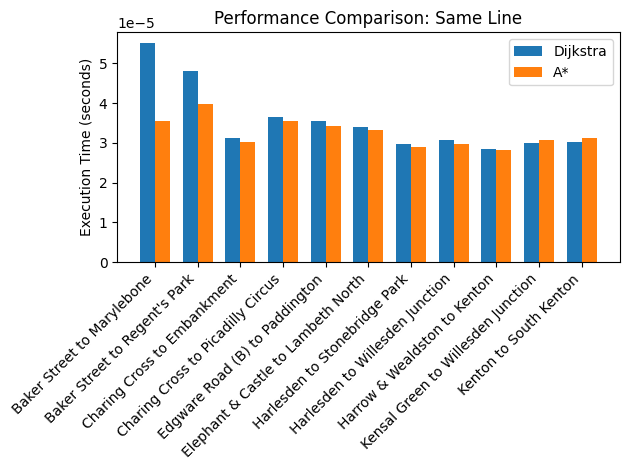

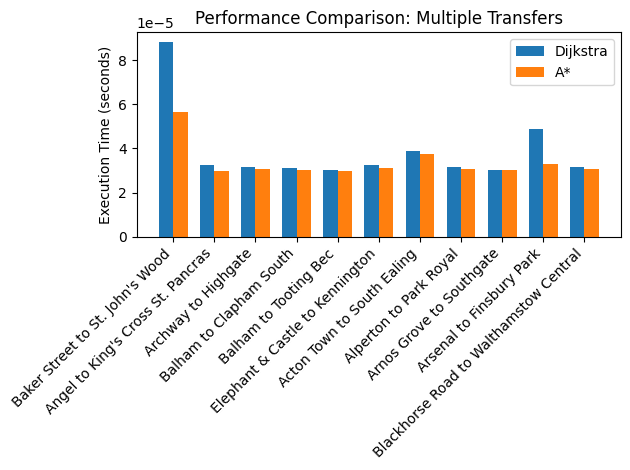

In [5]:

import csv
from math import radians, sqrt
import time
import matplotlib.pyplot as plt


class MinPriorityQueue:
    def __init__(self):
        self.heap = []

    def parent(self, i):
        return (i - 1) // 2

    def left_child(self, i):
        return 2 * i + 1

    def right_child(self, i):
        return 2 * i + 2

    def insert(self, val):
        self.heap.append(val)
        self._heapify_up(len(self.heap) - 1)

    def delete_min(self):
        if len(self.heap) == 0:
            return None  # Handle empty queue case

        self.heap[0], self.heap[-1] = self.heap[-1], self.heap[0]
        min_val = self.heap.pop()
        self._heapify_down(0)
        return min_val

    def _heapify_up(self, index):
        while index > 0 and self.heap[self.parent(index)] > self.heap[index]:
            self.heap[index], self.heap[self.parent(index)] = self.heap[self.parent(index)], self.heap[index]
            index = self.parent(index)

    def _heapify_down(self, index):
        while index < len(self.heap):
            smallest = index
            left = self.left_child(index)
            right = self.right_child(index)

            if left < len(self.heap) and self.heap[left] < self.heap[smallest]:
                smallest = left
            if right < len(self.heap) and self.heap[right] < self.heap[smallest]:
                smallest = right

            if smallest != index:
                self.heap[index], self.heap[smallest] = self.heap[smallest], self.heap[index]
                index = smallest
            else:
                break


    def put(self, node, priority):
        self.insert((priority, node))

    def is_empty(self):
        return len(self.heap) == 0
    
def dijkstra(graph, start, end):
    """
    Finds the shortest path from start to end using Dijkstra's algorithm.
    
    Parameters:
    - graph: The graph representation as a dict of dicts.
    - start: The starting node ID.
    - end: The ending node ID.
    
    Returns:
    - The shortest distance from start to end.
    - The path as a list of node IDs from start to end.
    """
    distance = {vertex: float('infinity') for vertex in graph}
    distance[start] = 0
    predecessor = {vertex: None for vertex in graph}
    pq = MinPriorityQueue()
    pq.put(start, 0)
    
    while not pq.is_empty():
        _, current_node = pq.delete_min() 
        
        if current_node == end:
            break

        for neighbor, weight in graph[current_node].items():
            alt_route = distance[current_node] + weight
            if alt_route < distance[neighbor]:
                distance[neighbor] = alt_route
                predecessor[neighbor] = current_node
                pq.put(neighbor, alt_route)  
                
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessor[current]
    path.reverse() 
    
    return distance[end], path



def euclidean_distance(coord1, coord2):
    """
    Calculate the Euclidean distance between two points in a plane.
    
    Parameters:
    - coord1: Tuple containing (latitude, longitude) of the first point.
    - coord2: Tuple containing (latitude, longitude) of the second point.
    
    Returns:
    - The Euclidean distance between the two points.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1

    distance = sqrt(delta_lat**2 + delta_lon**2)
    
    return distance


def heuristic(station_id, destination_id):
    station_coord = (stations[station_id]['latitude'], stations[station_id]['longitude'])
    destination_coord = (stations[destination_id]['latitude'], stations[destination_id]['longitude'])
    return euclidean_distance(station_coord, destination_coord)

def A_Star(graph, source, destination, heuristic):
    open_list = MinPriorityQueue()
    open_list.insert((0 + heuristic(source, destination), source))  # Corrected line
    predecessors = {source: None}
    costs = {source: 0}

    while not open_list.is_empty():
        _, current = open_list.delete_min()

        if current == destination:
            break

        for neighbor, weight in graph[current].items():
            new_cost = costs[current] + weight
            if neighbor not in costs or new_cost < costs[neighbor]:
                costs[neighbor] = new_cost
                priority = new_cost + heuristic(neighbor, destination)  # Corrected line
                open_list.insert((priority, neighbor))
                predecessors[neighbor] = current

    path = reconstruct_path(predecessors, source, destination)
    if not path:
        return predecessors, "Destination not reachable"

    return predecessors, path


def reconstruct_path(predecessors, start, end):
        if end not in predecessors:
            return []  # Path not found
        path = []
        while end is not None:
            path.append(end)
            end = predecessors.get(end)
        path.reverse()
        return path  


def parse_stations(file_path):
    """
    Parses the stations CSV file and returns a dictionary of stations.
    
    Parameters:
    - file_path: The path to the stations CSV file.
    
    Returns:
    - A dictionary where keys are station IDs and values are dictionaries
      containing latitude, longitude, and name of the station.
    """
    stations = {}
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            station_id = int(row["id"])
            stations[station_id] = {
                "latitude": float(row["latitude"]),
                "longitude": float(row["longitude"]),
                "name": row["name"]
            }
    return stations


def parse_connections(file_path):
    """
    Parses the connections CSV file and returns a list of connections.
    
    Parameters:
    - file_path: The path to the connections CSV file.
    
    Returns:
    - A list of tuples, each representing a connection between two stations.
      Each tuple contains (station1, station2, line, time).
    """
    connections = []
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header
        for row in reader:
            connection = (int(row[0]), int(row[1]), int(row[2]), float(row[3]))
            connections.append(connection)
    return connections

stations_file_path = 'london_stations.csv'
connections_file_path = 'london_connections.csv'

stations = parse_stations(stations_file_path)
connections = parse_connections(connections_file_path)




def build_graph(connections):
    """
    Builds a graph from a list of connections.
    Each connection is a tuple (station1, station2, time).

    Parameters:
    - connections: A list of tuples, where each tuple contains
      (station1, station2, time).

    Returns:
    - A dictionary representing the graph, where keys are station IDs
      and values are dictionaries of neighboring stations and their respective times.
    """
    graph = {}

    for station1, station2, _, time in connections:
        if station1 not in graph:
            graph[station1] = {}
        if station2 not in graph:
            graph[station2] = {}

        # Add the edge from station1 to station2 and vice versa
        graph[station1][station2] = time
        graph[station2][station1] = time  # Assuming bidirectional connections

    return graph


graph = build_graph(connections)


def measure_performance(graph, start_id, end_id, heuristic):
    # Measure Dijkstra's algorithm performance
    start_time = time.time()
    dijkstra(graph, start_id, end_id)
    dijkstra_time = time.time() - start_time

    # Measure A* algorithm performance
    start_time = time.time()
    A_Star(graph, start_id, end_id, heuristic)
    astar_time = time.time() - start_time

    return dijkstra_time, astar_time


def count_line_changes(path, connections):
    station_pairs_to_lines = {}
    for conn in connections:
        station1, station2, line, _ = conn
        if (station1, station2) not in station_pairs_to_lines:
            station_pairs_to_lines[(station1, station2)] = set()
        station_pairs_to_lines[(station1, station2)].add(line)
        
        if (station2, station1) not in station_pairs_to_lines:
            station_pairs_to_lines[(station2, station1)] = set()
        station_pairs_to_lines[(station2, station1)].add(line)

    line_changes = 0
    current_line = None
    for i in range(len(path) - 1):
        station1, station2 = path[i], path[i + 1]
        possible_lines = station_pairs_to_lines.get((station1, station2), set())
        

        if current_line not in possible_lines:
  
            for line in possible_lines:
                current_line = line
                break  
            
            if i > 0:
                line_changes += 1
                
    return line_changes


def plot_performance_comparison(labels, dijkstra, astar, title, image_name):
    """
    Plots a comparison of execution times between Dijkstra's and A* algorithms.

    Parameters:
    - labels: List of strings representing the labels for each station pair.
    - dijkstra_times: List of execution times for Dijkstra's algorithm.
    - astar_times: List of execution times for A* algorithm.
    - title: (Optional) Title for the plot.
    """
    x = range(len(labels))
    width = 0.35  

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, dijkstra, width, label='Dijkstra')
    rects2 = ax.bar([p + width for p in x], astar, width, label='A*')

    ax.set_ylabel('Execution Time (seconds)')
    ax.set_title(title)
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()

    #plt.show()
    plt.savefig(image_name)
    

station_pairs_same_line = [
    (11,163),
    (11,212),
    (49,87),
    (49,197),
    (82,193),
    (84,148),
    (113,246),
    (113,298),
    (114,140),
    (137, 298),
    (140,237)
]
station_pairs_adjacent_lines = [
    
    
    
    
    
]
station_pairs_multiple_transfers = [
    (11,249),
    (7,145),
    (8,124),
    (12,56),
    (12,257),
    (84,136),
    (1,234),
    (5,194),
    (9,232),
    (10,95),
    (26,274)
    
]
# Collect data
labels_same_line = []
dijkstra_times_same_line = []
astar_times_same_line = []


print("Time Comparison between Dijkstra's and A* Algorithms: same line")
print("---------------------------------------------------------------------------------------------------")
for start_id, end_id in station_pairs_same_line:

    dijkstra_time1,_ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time1,_ = measure_performance(graph, start_id, end_id, heuristic)
    labels_same_line.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times_same_line.append(dijkstra_time1)
    astar_times_same_line.append(astar_time1)
    

    print(f"Pair: {labels_same_line[-1]}, Dijkstra Time: {dijkstra_time1:.6f}, A* Time: {astar_time1:.6f}")
print("---------------------------------------------------------------------------------------------------")

plot_performance_comparison(labels_same_line, dijkstra_times_same_line, astar_times_same_line, "Performance Comparison: Same Line", "same_line.png")

dijkstra_times_adjacent_lines = []
astar_times_adjacent_lines = []
labels_adjacent_lines = []
print("Time Comparison between Dijkstra's and A* Algorithms: Ajacent Line transfers")
print("---------------------------------------------------------------------------------------------------")


print("---------------------------------------------------------------------------------------------------")


dijkstra_times_multiple_transfers = []
astar_times_multiple_transfers = []
labels_multiple_transfers = []  
print("Time Comparison between Dijkstra's and A* Algorithms: Multiple Line transfers")
print("---------------------------------------------------------------------------------------------------")
for start_id, end_id in station_pairs_multiple_transfers:

    dijkstra_time2,_ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time2,_ = measure_performance(graph, start_id, end_id, heuristic)
    labels_multiple_transfers.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times_multiple_transfers.append(dijkstra_time2)
    astar_times_multiple_transfers.append(astar_time2)
    

    print(f"Pair: {labels_multiple_transfers[-1]}, Dijkstra Time: {dijkstra_time2:.6f}, A* Time: {astar_time2:.6f}")
print("---------------------------------------------------------------------------------------------------")

plot_performance_comparison(labels_multiple_transfers, dijkstra_times_multiple_transfers, astar_times_multiple_transfers, "Performance Comparison: Multiple Transfers", "multiple_transfer.png")



station_pairs = [
    (1, 234),  # Short distance
    (10, 150),  # Medium distance
    (50, 200),  # Long distance
    (11, 212),  # Same Line, Short Distance
    (13, 301),  # Same Line, Long Distance
    (11, 87),   # Different Lines, No Transfers
    (3, 295),   # Different Lines, Multiple Transfers
    (117, 42),  # Heathrow Terminals 1, 2 & 3 to Canary Wharf
    (282, 247), # Wembley Park to Stratford
    (88, 299),  # Epping to Wimbledon
    (35, 192),  # Brixton to Oxford Circus
    (280, 167),  # Watford to Moorgate
    (6,70)

]


line_changes_list = []
print("Line Change Comparison between Dijkstra's and A* Algorithms:")
print("---------------------------------------------------------------------------------------------------" )
for (start_id, end_id), label in zip(station_pairs, labels):
    _, dijkstra_path = dijkstra(graph, start_id, end_id)
    _, astar_path = A_Star(graph, start_id, end_id, heuristic)
   
    dijkstra_line_changes = count_line_changes(dijkstra_path, connections)
    astar_line_changes = count_line_changes(astar_path, connections)
    
    line_changes_list.append((dijkstra_line_changes, astar_line_changes))

    print(f"Pair: {label}, Dijkstra Line Changes: {dijkstra_line_changes}, A* Line Changes: {astar_line_changes}")
    
    

In [20]:
from abc import ABC, abstractmethod
from typing import Dict, Tuple, List


class Graph(ABC):
    def __init__(self):
        self.edges = {}  # Stores adjacency list
        
    @property
    def nodes(self):
        return list(self.edges.keys())
    
    def add_node(self, node: int):
        if node not in self.edges:
            self.edges[node] = []
    
    def add_edge(self, src: int, dst: int):
        if src not in self.edges:
            self.add_node(src)
        if dst not in self.edges:
            self.add_node(dst)
        self.edges[src].append(dst)
        self.edges[dst].append(src)  # Assuming undirected graph for simplicity

    def get_num_of_nodes(self) -> int:
        return len(self.edges)

    def get_adj_nodes(self, node: int) -> List[int]:
        return self.edges.get(node, [])

    @abstractmethod
    def w(self, node: int) -> float:
        # Abstract method, should be implemented in child classes
        pass

    
class WeightedGraph(Graph):
    def __init__(self):
        super().__init__()
        self.edges = {}  # Overrides the base class to use a dict for weighted edges

    def add_edge(self, src: int, dst: int, weight: float):
        if src not in self.edges:
            self.edges[src] = {}
        if dst not in self.edges:
            self.edges[dst] = {}
        self.edges[src][dst] = weight
        self.edges[dst][src] = weight  # Assuming undirected graph for simplicity

    def w(self, node1: int, node2: int) -> float:
        try:
            return self.edges[node1][node2]
        except KeyError:
            return float('inf')  # No edge exists



class HeuristicGraph(WeightedGraph):
    def __init__(self, heuristic: Dict[int, float]):
        super().__init__()
        self.heuristic = heuristic

    def get_heuristic(self, node): 
        return self.heuristic.get(node, float('inf'))

class SPAlgorithm(ABC):
    def __init__(self, graph: Graph):
        self.graph = graph

    @abstractmethod
    def calc_sp(self, source: int, dest: int) -> Tuple[List[int], float]:
        pass

class Dijkstra(SPAlgorithm):
    def __init__(self, graph: WeightedGraph):
        super().__init__(graph)
    
    def calc_sp(self, source, dest):
        distance = {vertex: float('infinity') for vertex in self.graph.nodes}
        distance[source] = 0
        pq = PriorityQueue()
        pq.put(source, 0)
        visited = set()
        predecessor = {vertex: None for vertex in self.graph.nodes}
        
        while not pq.is_empty():
            current_vertex = pq.get()
            
            if current_vertex in visited:
                continue
            visited.add(current_vertex)
            
            if current_vertex == dest:
                break
            
            for neighbor in self.graph.get_adj_nodes(current_vertex):
                if neighbor in visited:
                    continue
                alt_route = distance[current_vertex] + self.graph.w(current_vertex, neighbor)
                if alt_route < distance[neighbor]:
                    distance[neighbor] = alt_route
                    pq.put(neighbor, alt_route)
                    predecessor[neighbor] = current_vertex
        
        # Reconstruct path
        path = []
        current = dest
        while current is not None and current in predecessor:
            path.append(current)
            current = predecessor[current]
        path.reverse()
        
        return path, distance[dest] if distance[dest] != float('infinity') else float('inf')


class A_Star_Adapter(SPAlgorithm):
    def __init__(self, heuristic_graph: HeuristicGraph):
        super().__init__(heuristic_graph)
        self.heuristic_graph = heuristic_graph

    def calc_sp(self, source: int, dest: int) -> Tuple[List[int], float]:
        graph = {node: {} for node in self.heuristic_graph.nodes}
        for node, neighbors in self.heuristic_graph.edges.items():
            for neighbor in neighbors:
                if neighbor in self.heuristic_graph.edges[node]: 
                    graph[node][neighbor] = self.heuristic_graph.w(node, neighbor)
        
        heuristic = {node: self.heuristic_graph.get_heuristic(node) for node in self.heuristic_graph.nodes}

        _, path = self.a_star_algorithm(graph, source, dest, heuristic)

        if not path:
            return [], float('inf') 

        path_cost = sum([self.heuristic_graph.w(path[i], path[i+1]) for i in range(len(path) - 1)])
        
        return path, path_cost

    def a_star_algorithm(self, graph, source, destination, heuristic):
        open_list = PriorityQueue()
        open_list.put(source, 0 + heuristic[source])
        predecessors = {source: None}
        costs = {source: 0}

        while not open_list.is_empty():
            current = open_list.get()

            if current == destination:
                break

            
            for neighbor, weight in graph[current].items():
                new_cost = costs[current] + weight

                if neighbor not in costs or new_cost < costs[neighbor]:
                    costs[neighbor] = new_cost
                    priority = new_cost + heuristic[neighbor]
                    open_list.put(neighbor, priority)
                    predecessors[neighbor] = current

        path = self.reconstruct_path(predecessors, source, destination)
        if not path:
            return predecessors, [], "Destination not reachable"

        return predecessors, path

    def reconstruct_path(self, predecessors, start, end):
        if end not in predecessors:
            return []  # Path not found
        path = []
        while end is not None:
            path.append(end)
            end = predecessors.get(end)
        path.reverse()  # Reverse the path to start from the beginning
        return path

    
class BellmanFord(SPAlgorithm):
    def calc_sp(self, source: int, dest: int) -> Tuple[List[int], float]:
        # Initialize distance to all vertices as infinite and distance to source as 0
        distances = {v: float('inf') for v in self.graph.nodes}
        predecessors = {v: None for v in self.graph.nodes}
        distances[source] = 0

        # Relax edges repeatedly
        for _ in range(len(self.graph.nodes) - 1):
            for src in self.graph.edges:
                for dst, weight in self.graph.edges[src].items():
                    if distances[src] + weight < distances[dst]:
                        distances[dst] = distances[src] + weight
                        predecessors[dst] = src

        # Check for negative-weight cycles
        for src in self.graph.edges:
            for dst, weight in self.graph.edges[src].items():
                if distances[src] + weight < distances[dst]:
                    raise ValueError("Graph contains a negative-weight cycle")

        # Reconstruct the path from source to dest
        path = []
        current = dest
        while current is not None:
            path.append(current)
            current = predecessors[current]
        path.reverse()

        return path, distances[dest] if distances[dest] != float('inf') else None

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def is_empty(self):
        return not self.elements

    def put(self, item, priority):
        self.elements.append((priority, item))
        self.elements.sort(reverse=True)

    def get(self):
        return self.elements.pop()[1]  


class ShortPathFinder:
    def __init__(self, graph: Graph, algo: SPAlgorithm):
        self.graph = graph
        self.algo = algo

    def calc_short_path(self, source: int, dest: int) -> Tuple[List[int], float]:
        return self.algo.calc_sp(source, dest)

    def set_graph(self, graph: Graph):
        self.graph = graph
        self.algo.graph = graph

    def set_algorithm(self, algo: SPAlgorithm):
        self.algo = algo


"""Detailed testing to ensure that everything is working or not"""
def create_test_graph():
    graph = WeightedGraph()
    graph.add_edge(1, 2, 1.0)
    graph.add_edge(2, 3, 2.0)
    graph.add_edge(3, 4, 3.0)
    graph.add_edge(4, 5, 4.0)
    graph.add_edge(1, 5, 10.0)
    return graph

def create_heuristic_graph():
    heuristic = {1: 9, 2: 7, 3: 4, 4: 2, 5: 0}  # Example heuristic, assuming 5 is the goal
    graph = HeuristicGraph(heuristic)
    graph.add_edge(1, 2, 1.0)
    graph.add_edge(2, 3, 2.0)
    graph.add_edge(3, 4, 3.0)
    graph.add_edge(4, 5, 4.0)
    graph.add_edge(1, 5, 10.0)
    print(graph.edges)
    return graph

def test_dijkstra_simple_path():
    graph = create_test_graph()
    dijkstra_algo = Dijkstra(graph)
    finder = ShortPathFinder(graph, dijkstra_algo)
    path, cost = finder.calc_short_path(1, 5)
    print(path, cost)


def test_a_star_simple_path():
    graph = create_heuristic_graph()
    a_star_algo = A_Star_Adapter(graph)
    finder = ShortPathFinder(graph, a_star_algo)
    path, cost = finder.calc_short_path(1, 5)
    print(path, cost)


def test_dijkstra_disconnected_graph():
    graph = WeightedGraph()
    graph.add_edge(1, 2, 1.0)
    graph.add_edge(3, 4, 1.0)  # Disconnected component
    dijkstra_algo = Dijkstra(graph)
    finder = ShortPathFinder(graph, dijkstra_algo)
    path, cost = finder.calc_short_path(1, 4)
    print(path, cost)

def test_bellman_ford_negative_cycle():
    graph = WeightedGraph()
    graph.add_edge(1, 2, 4.0)
    graph.add_edge(2, 3, -6.0)
    graph.add_edge(3, 1, 2.0)
    bellman_ford_algo = BellmanFord(graph)
    finder = ShortPathFinder(graph, bellman_ford_algo)
    try:
        path, cost = finder.calc_short_path(1, 3)
        assert False, "Negative cycle detection failed"
    except ValueError as e:
        assert str(e) == "Graph contains a negative-weight cycle", "Incorrect error message"
    print("Test Case 4 Passed: Bellman-Ford Negative Weight Cycle")
def test_a_star_adapter():
    # Test case 1
    graph1 = HeuristicGraph({0: 2, 1: 1, 2: 0})
    graph1.add_edge(0, 1, 1)
    graph1.add_edge(1, 2, 1)
    a_star1 = A_Star_Adapter(graph1)
    print(a_star1.calc_sp(0, 2))  # Expected: ([0, 1, 2], 2)

    # Test case 2
    graph2 = HeuristicGraph({0: 2, 1: 1, 2: 1, 3: 0})
    graph2.add_edge(0, 1, 1)
    graph2.add_edge(0, 2, 5)
    graph2.add_edge(1, 3, 1)
    graph2.add_edge(2, 3, 1)
    a_star2 = A_Star_Adapter(graph2)
    print(a_star2.calc_sp(0, 3))  # Expected: ([0, 1, 3], 2)

    # Test case 3
    graph3 = HeuristicGraph({0: 3, 1: 2, 2: 1, 3: 0})
    graph3.add_edge(0, 1, 1)
    graph3.add_edge(1, 2, 1)
    graph3.add_edge(2, 1, 1)
    graph3.add_edge(2, 3, 1)
    a_star3 = A_Star_Adapter(graph3)
    print(a_star3.calc_sp(0, 3))  # Expected: ([0, 1, 2, 3], 3)

    # Test case 4
    graph4 = HeuristicGraph({0: 1, 1: 2, 2: 1, 3: 0})
    graph4.add_edge(0, 1, 1)
    graph4.add_edge(0, 2, 2)
    graph4.add_edge(0, 3, 3)
    a_star4 = A_Star_Adapter(graph4)
    print(a_star4.calc_sp(0, 3))  # Expected: ([0, 3], 3)

if __name__ == "__main__":
    test_dijkstra_simple_path()
    test_a_star_simple_path()
    test_dijkstra_disconnected_graph()
    test_bellman_ford_negative_cycle()
    test_a_star_adapter()


[1, 5] 10.0
{1: {2: 1.0, 5: 10.0}, 2: {1: 1.0, 3: 2.0}, 3: {2: 2.0, 4: 3.0}, 4: {3: 3.0, 5: 4.0}, 5: {4: 4.0, 1: 10.0}}
[1, 5] 10.0
[4] inf
Test Case 4 Passed: Bellman-Ford Negative Weight Cycle
([0, 1, 2], 2)
([0, 1, 3], 2)
([0, 1, 2, 3], 3)
([0, 3], 3)
